In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import gc
import matplotlib.pyplot as plt
import zipfile

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
trained_model_path = "./trained_models/ResNet-v3.pth"

SEED = 42
TEST_SIZE = 0.3
VALIDATION_SIZE = 0.1


# Flags
OPTIMIZE_HYPERPARAMETERS = False
LOAD_TRAINED_MODEL = True
TRAIN_MODEL = False

!gdown 1fpMwmb5X0EYBof5ZlrgbqwkxqLxuVVsy
!gdown 1x6XQuxGhlO88CwN1FBzqg5lYk_I1ZM7g
zip_file_path_ds = 'datasets.zip'
zip_file_path_tm = 'trained_models.zip'

with zipfile.ZipFile(zip_file_path_ds, 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile(zip_file_path_tm, 'r') as zip_ref:
    zip_ref.extractall()

cuda
Downloading...
From (original): https://drive.google.com/uc?id=1fpMwmb5X0EYBof5ZlrgbqwkxqLxuVVsy
From (redirected): https://drive.google.com/uc?id=1fpMwmb5X0EYBof5ZlrgbqwkxqLxuVVsy&confirm=t&uuid=ad76be92-cf1c-490a-b8d0-af131464b6c9
To: /content/datasets.zip
100% 1.23G/1.23G [00:25<00:00, 48.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1x6XQuxGhlO88CwN1FBzqg5lYk_I1ZM7g
From (redirected): https://drive.google.com/uc?id=1x6XQuxGhlO88CwN1FBzqg5lYk_I1ZM7g&confirm=t&uuid=c0899d81-185c-4e17-ad5e-e91a87274e27
To: /content/trained_models.zip
100% 236M/236M [00:04<00:00, 47.6MB/s]


## Load the data into DataLoader
In this step, data is reshaped and normalized
- Normalization helps eliminate the effects of lighting (brightness, contrast, etc.) and other factors that may affect the image, leading to better training performance.


In [2]:
def data_loader(data_path, batch_size, random_seed=SEED, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE, shuffle=True):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    dataset = datasets.ImageFolder(data_path, transform=transform)

    train_data, test_data = random_split(dataset, [1-test_size, test_size])

    # load the dataset
    training_dataset = train_data
    validation_dataset = train_data

    num_train = len(training_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, sampler=train_sampler)

    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=batch_size, sampler=valid_sampler)

    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)

    return (training_loader, validation_loader, test_loader)

dataset_path = "./datasets/Colorectal Cancer"

training_loader, test_loader, test_loader = data_loader(data_path=dataset_path, batch_size=64, test_size=0.3)

## Model Definition
This section contains the definitions for the ResNET model

In [3]:
from itertools import product


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()

        # convolutional layers
        self.convolution_layer_1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.convolution_layer_2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))

        self.downsample = downsample

        # activation function
        self.relu = nn.ReLU()

        # numebr of output layers
        self.out_channels = out_channels

    def forward(self, x):
        residual = x

        output = self.convolution_layer_1(x)
        output = self.convolution_layer_2(output)

        if self.downsample:
            residual = self.downsample(x)

        output += residual
        output = self.relu(output)

        return output

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.convolutional_layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.max_pooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer0 = self._generate_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._generate_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._generate_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._generate_layer(block, 512, layers[3], stride = 2)

        self.average_pooling = nn.AvgPool2d(7, stride=1)

        self.fully_connected = nn.Linear(512, num_classes)

    def _generate_layer(self, block, planes, blocks, stride=1):
        downsample = None

        # downsample when the width/height of the output is smaller than the input or the stride is > 1
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.convolutional_layer_1(x)
        x = self.max_pooling(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x

## Finding best hyperparameter values by performing a grid search

In [4]:
# Grid search parameters
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.05, 0.1]

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001
num_epochs = 30

if OPTIMIZE_HYPERPARAMETERS:
    grid_search_results = {}

    criterion = nn.CrossEntropyLoss()

    # Perform grid search
    for bs, lr in product(batch_sizes, learning_rates):
        print(f"\nTraining with batch_size={bs}, learning_rate={lr}")

        # Update parameters
        batch_size = bs
        learning_rate = lr

        # Reinitialize model and optimizer
        model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    momentum=momentum,
                                    weight_decay=weight_decay)

        # Training loop
        train_losses = []
        validation_losses = []
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, (images, labels) in enumerate(training_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                del images, labels, outputs

            # Calculate average training loss for epoch
            train_epoch_loss = running_loss / len(training_loader)
            train_losses.append(train_epoch_loss)

            # Calculate validation loss
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()

            val_epoch_loss = val_running_loss / len(test_loader)
            validation_losses.append(val_epoch_loss)

            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

        # Plot training vs validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training vs Validation Loss (batch_size={bs}, learning_rate={lr})')
        plt.legend()
        plt.show()

        # Store results
        grid_search_results[(bs, lr)] = min(validation_losses)

    # Plot grid search results
    plt.figure(figsize=(10, 8))
    for bs in batch_sizes:
        val_losses = [grid_search_results[(bs, lr)] for lr in learning_rates]
        plt.plot(learning_rates, val_losses, label=f'Batch Size {bs}')

    plt.xlabel('Learning Rate')
    plt.ylabel('Best Validation Loss')
    plt.title('Grid Search Results: Learning Rate vs Validation Loss')
    plt.legend()
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    # Find best parameters
    best_params = min(grid_search_results.items(), key=lambda x: x[1])
    print(f"\nBest parameters: batch_size={best_params[0][0]}, learning_rate={best_params[0][1]}")
    print(f"Best validation loss: {best_params[1]:.4f}")

    # batch_size = best_params[0][0]
    # learning_rate = best_params[0][1]


## Training the Model

In [5]:
## Training the Model
batch_size = 32
num_epochs = 30
learning_rate = 0.01

model = ResNet(ResidualBlock, [2, 4, 6, 3]).to(device)

if LOAD_TRAINED_MODEL:
    model.load_state_dict(torch.load(trained_model_path,map_location=torch.device('cuda')))

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)

#Train the model
total_step = len(training_loader)

train_validation_loss = []

if not LOAD_TRAINED_MODEL:
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(training_loader):
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # free up memory that is no longer in use
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

      # Validation
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              # move tensors to device
              images = images.to(device)
              labels = labels.to(device)

              # get predictions
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)

              # update total and correct
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              # free up memory
              del images, labels, outputs

          print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

      # Calculate and store training loss
      train_loss = 0.0
      with torch.no_grad():
          for images, labels in training_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              train_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          train_loss /= len(training_loader)

      # Calculate and store validation loss
      test_loss = 0.0
      with torch.no_grad():
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              test_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          test_loss /= len(test_loader)

      train_validation_loss.append({"train": train_loss, "test": test_loss})

  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_validation_loss) + 1)
  train_losses = [x["train"] for x in train_validation_loss]
  val_losses = [x["test"] for x in train_validation_loss]

  # Calculate mean and std for both losses
  train_mean, train_std = np.mean(train_losses), np.std(train_losses)
  val_mean, val_std = np.mean(val_losses), np.std(val_losses)

  # Filter data within 2 standard deviations
  train_mask = np.abs(train_losses - train_mean) <= 2 * train_std
  val_mask = np.abs(val_losses - val_mean) <= 2 * val_std

  # Plot filtered data
  plt.plot(np.array(epochs)[train_mask], np.array(train_losses)[train_mask],
           color="blue", label='Training Loss')
  plt.plot(np.array(epochs)[val_mask], np.array(val_losses)[val_mask],
           color="orange", label='Test Loss')
  plt.title('Training and Test Loss over Epochs (Within 2σ)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  torch.save(model.state_dict(), trained_model_path)

<ipython-input-5-c9b685e64d20>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_model_path,map_location=torch.device('cuda')))


## Test the model

In [6]:
if TRAIN_MODEL:
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            # move tensors to device
            images = images.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # update total and correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # free up memory
            del images, labels, outputs

        print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

## Feature Extraction of the trained encoder

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import matplotlib.colors as mcolors

# feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

## Function to get the features

In [8]:
def encoding(model,test_loader):
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()
    preencoded_features = []
    encoded_features = []
    labels_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            preencoded = images.view(images.size(0), -1).cpu().numpy()
            preencoded_features.append(preencoded)

            encoded = feature_extractor(images).cpu().numpy()
            encoded_features.append(encoded)

            labels_list.append(labels.numpy())

            del images, encoded
            torch.cuda.empty_cache()

    # Concatenate features and labels
    preencoded_features = np.concatenate(preencoded_features)
    encoded_features = np.concatenate(encoded_features)
    labels_list = np.concatenate(labels_list)

    tsne_2d = TSNE(n_components=2, random_state=42)
    tsne_3d = TSNE(n_components=3, random_state=42)

    encoded_tsne_2d = tsne_2d.fit_transform(encoded_features)
    encoded_tsne_3d = tsne_3d.fit_transform(encoded_features)

    preencoded_tsne_2d = tsne_2d.fit_transform(preencoded_features)
    preencoded_tsne_3d = tsne_3d.fit_transform(preencoded_features)

    return encoded_tsne_2d,encoded_tsne_3d,preencoded_tsne_2d,preencoded_tsne_3d,preencoded_features,encoded_features,labels_list

In [9]:
def plot_tsne_2d(preencoded, encoded, labels, axes, label_tags=["class 1", "class 2", "class 3"]):
      # Define a discrete colormap with boundaries based on unique labels
      unique_labels = np.unique(labels)
      cmap = plt.get_cmap('tab10', len(unique_labels))
      norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))

      scatter1 = axes[0].scatter(preencoded[:, 0], preencoded[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.6)
      axes[0].set_title(f'Preencoded Features - 3D')
      cbar1 = fig.colorbar(scatter1, ax=axes[0], shrink=0.7, ticks=unique_labels)
      cbar1.set_label('Labels')
      cbar1.set_ticks(unique_labels)
      cbar1.set_ticklabels(label_tags)


      scatter2 = axes[1].scatter(encoded[:, 0], encoded[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.6)
      axes[1].set_title(f'Encoded Features - 2D')
      cbar2 = fig.colorbar(scatter2, ax=axes[1], shrink=0.7, ticks=unique_labels)
      cbar2.set_label('Labels')
      cbar2.set_ticks(unique_labels)
      cbar2.set_ticklabels(label_tags)


def plot_tsne_3d(preencoded, encoded, labels, label_tags=["class 1", "class 2", "class 3"]):
    # Define a discrete colormap with boundaries based on unique labels
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab10', len(unique_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))

    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    scatter1 = ax1.scatter(preencoded[:, 0], preencoded[:, 1], preencoded[:, 2], c=labels, cmap=cmap, norm=norm, alpha=0.6)
    ax1.set_title(f'Preencoded Features - 2D')
    cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.7, ticks=unique_labels)
    cbar1.set_label('Labels')
    cbar1.set_ticks(unique_labels)
    cbar1.set_ticklabels(label_tags)

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    scatter2 = ax2.scatter(encoded[:, 0], encoded[:, 1], encoded[:, 2], c=labels, cmap=cmap, norm=norm, alpha=0.6)
    ax2.set_title(f'Encoded Features - 2D')
    cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.7, ticks=unique_labels)
    cbar2.set_label('Labels')
    cbar2.set_ticks(unique_labels)
    cbar2.set_ticklabels(label_tags)




## Visualizing TSNE Feature extractions from dataset 1 with custom ResNet-34

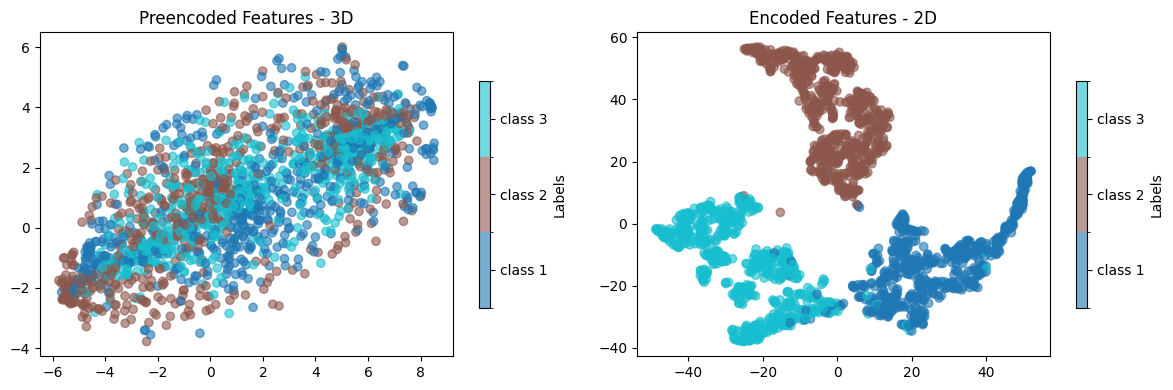

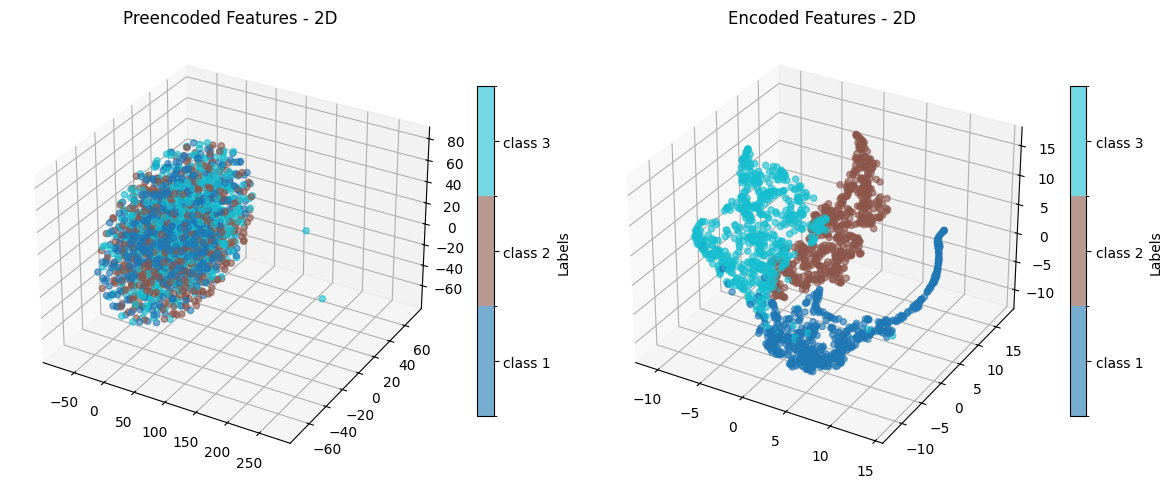

In [10]:
encoded_tsne_2d,encoded_tsne_3d,preencoded_tsne_2d,preencoded_tsne_3d,preencoded_features,encoded_features,labels_list = encoding(model,test_loader)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_tsne_2d(preencoded_tsne_2d, encoded_tsne_2d, labels_list, axs)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 10))
plot_tsne_3d(preencoded_tsne_3d, encoded_tsne_3d, labels_list)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

**TASK 2**

---

Visualize feature extraction for Dataset 2 and 3.  
1. Use our trained ResNet-34 on Dataset 1
2. Use Trained ResNet-34 on IMAGENET

Train on classic ML model


Function to load whole dataset

In [11]:
def full_data_loader(data_path, batch_size,shuffle=True):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])

    # define transforms
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.ImageFolder(data_path, transform=transform)

    full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return full_loader

Function to visualize encoded extracted features

In [12]:
def visualize(model,test_loader,label_tags, title):
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()
    preencoded_features = []
    encoded_features = []
    labels_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            preencoded = images.view(images.size(0), -1).cpu().numpy()
            preencoded_features.append(preencoded)

            encoded = feature_extractor(images).cpu().numpy()
            encoded_features.append(encoded)

            labels_list.append(labels.numpy())

            del images, encoded
            torch.cuda.empty_cache()

    encoded_features = np.concatenate(encoded_features)
    labels_list = np.concatenate(labels_list)

    tsne_2d = TSNE(n_components=2, random_state=42)
    encoded_tsne_2d = tsne_2d.fit_transform(encoded_features)
    fig, axes = plt.subplots(figsize=(12, 4))

    # Define a discrete colormap with boundaries based on unique labels
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab10', len(unique_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))

    scatter1 = axes.scatter(encoded_tsne_2d[:, 0], encoded_tsne_2d[:, 1], c=labels_list, cmap=cmap, norm=norm, alpha=0.6)
    axes.set_title(title)
    cbar1 = fig.colorbar(scatter1, ax=axes, shrink=0.7, ticks=unique_labels)
    cbar1.set_label('Labels')
    cbar1.set_ticks(unique_labels)
    cbar1.set_ticklabels(label_tags)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.tight_layout()
    plt.show()

    return feature_extractor

Defining Models

In [13]:
from torchvision.models import resnet34, ResNet34_Weights

# Initializing ResNet-34 pre-trained on IMAGENET
model_on_imageNet = resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 124MB/s]


## Dataset 2

In [14]:
dataset_path_prostate = "./datasets/Prostate Cancer"

prostate_full_loader = full_data_loader(dataset_path_prostate, batch_size=64)

label_tags_prostate=["gland", "nongland", "tumor"]

# Custom ResNet-34

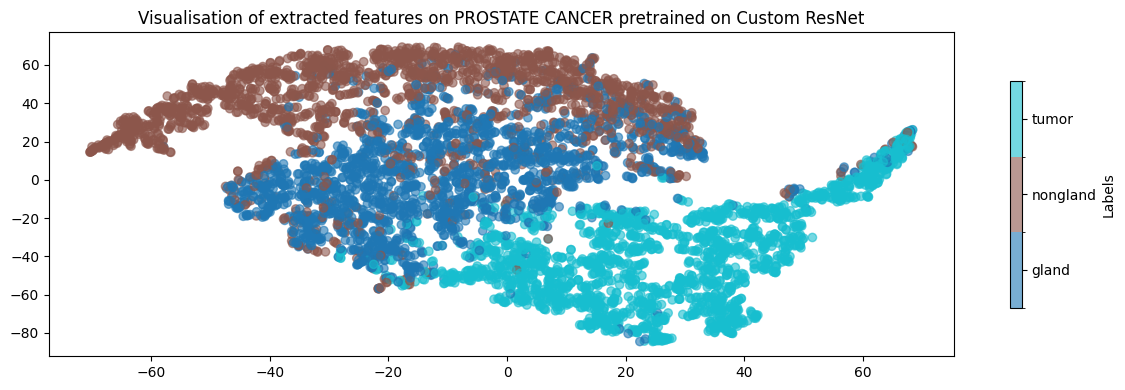

In [15]:
custom_resnet_prostate_ef = visualize(model,prostate_full_loader,label_tags_prostate,'Visualisation of extracted features on PROSTATE CANCER pretrained on Custom ResNet')

# Pre-Trained on ImageNet

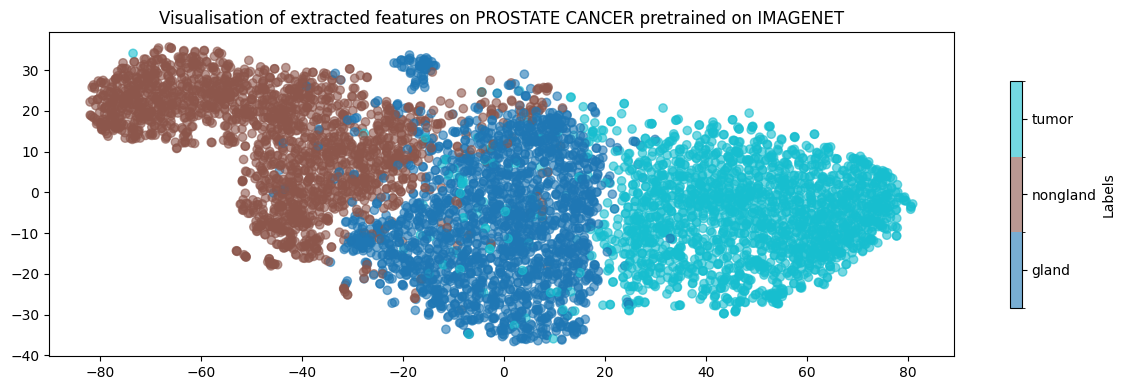

In [16]:
prostate_extracted_features = visualize(model_on_imageNet,prostate_full_loader,label_tags_prostate,'Visualisation of extracted features on PROSTATE CANCER pretrained on IMAGENET')

Dataset 3

In [17]:
dataset_path_animal = "./datasets/Animal Faces"

animal_full_loader = full_data_loader(dataset_path_animal, batch_size=64)

label_tags_animals = ["cat", "dog", "wild"]

# Custom ResNet-34

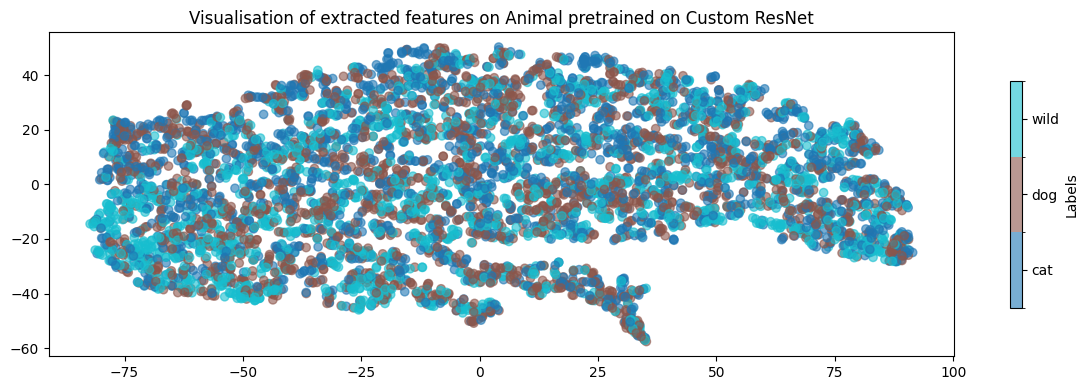

In [18]:
custom_resnet_animal_ef = visualize(model,animal_full_loader,label_tags_animals,'Visualisation of extracted features on Animal pretrained on Custom ResNet')

# Pre-Trained on ImageNet

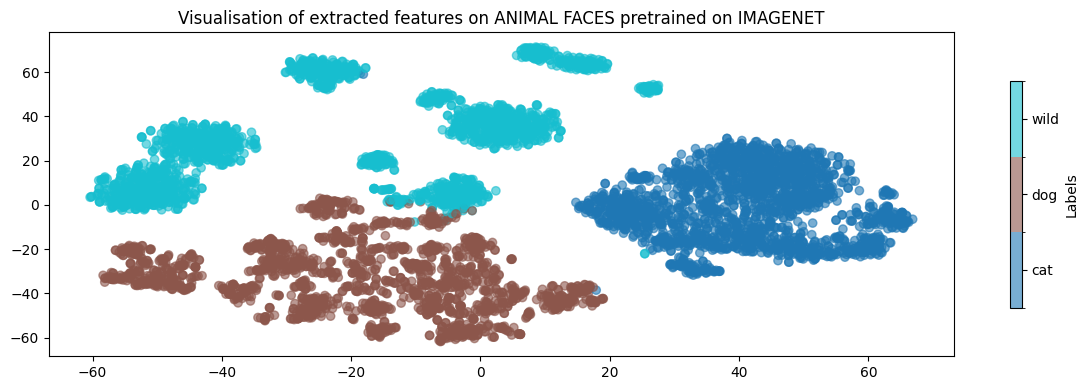

In [19]:
animal_extracted_features = visualize(model_on_imageNet,animal_full_loader,label_tags_animals,'Visualisation of extracted features on ANIMAL FACES pretrained on IMAGENET')

# Classification

## Function to save features

In [20]:
def saveFeatures(full_loader,feature_extractor,type):
    features = []
    labels = []

    with torch.no_grad():
        for images, target in full_loader:
            images = images.to(device)
            output = feature_extractor(images)
            features.append(output.cpu().numpy())
            labels.append(target.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels

# Function to plot decision boundaries for SVM

In [21]:
def plot_decision_boundaries(X, y, model, title, ax):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax)

# Function to confusion matrix

In [22]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_tags_prostate)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Random Forest for Dataset 2

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

features, labels = saveFeatures(prostate_full_loader,prostate_extracted_features,'Prostate')

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_2d, labels, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_tags_prostate))

Random Forest Accuracy: 96.67%
              precision    recall  f1-score   support

       gland       0.94      0.97      0.95       401
    nongland       0.97      0.97      0.97       384
       tumor       0.99      0.96      0.98       415

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



# Confusion Matrix

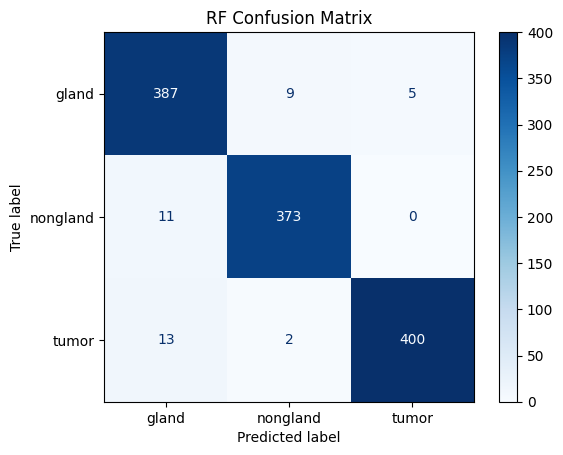

In [25]:
plot_confusion_matrix(y_test, y_pred, "RF Confusion Matrix")

# SVM for dataset 3

In [26]:
from sklearn.svm import SVC

features, labels = saveFeatures(animal_full_loader,animal_extracted_features,'animal')

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_2d, labels, test_size=0.2, random_state=42)

#Training
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_tags_animals))

SVM Accuracy: 98.58%
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       397
         dog       1.00      0.97      0.98       419
        wild       0.96      0.99      0.98       384

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



Plottig decision boundaries

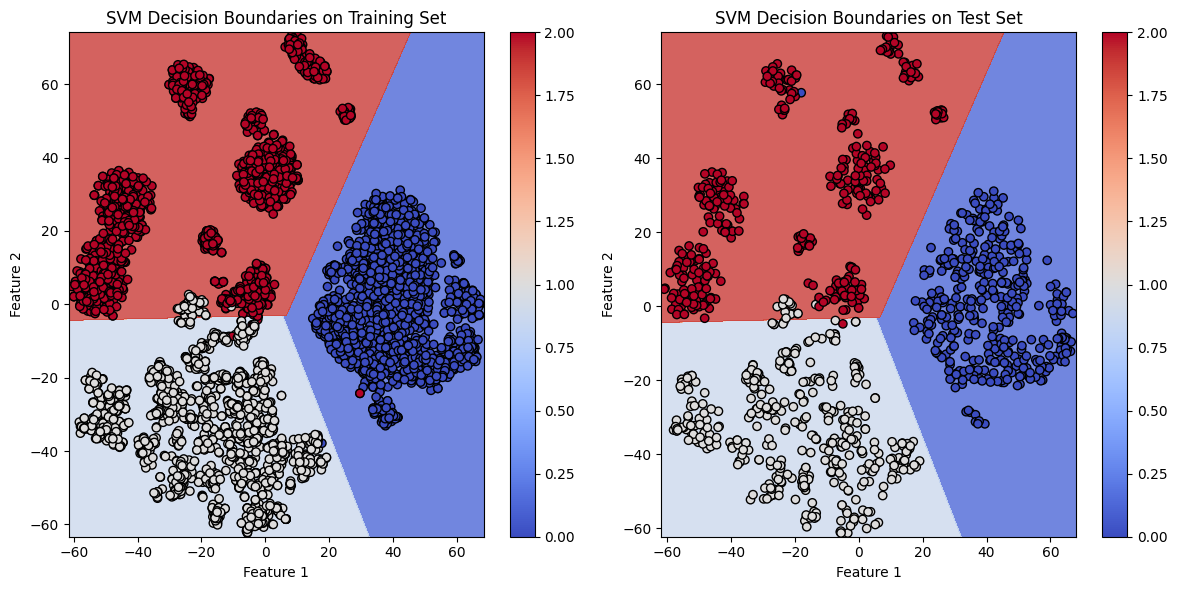

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_decision_boundaries(X_train, y_train, svm_clf, "SVM Decision Boundaries on Training Set", axes[0])

plot_decision_boundaries(X_test, y_test, svm_clf, "SVM Decision Boundaries on Test Set", axes[1])

plt.tight_layout()

# Confusion Matrix

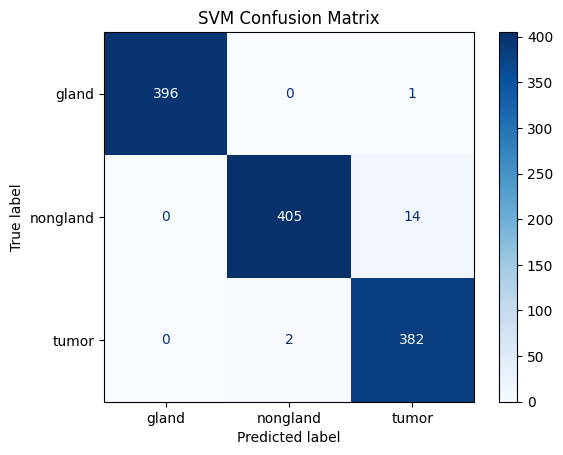

In [28]:
plot_confusion_matrix(y_test, y_pred, "SVM Confusion Matrix")